In [1]:
from lib.Base64Converter import path_to_base64
from lib.Polygon import PolygonSet
from lib.SMILE import SMILE
import matplotlib.pyplot as plt

sss=SMILE("../input.png","../tout.png")

#sss.find_mouse()

#
#sss.tooth.polygons

/Users/chc/gits/SMILE/app/lib/SMILE


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


100%|██████████| 131/131 [02:00<00:00,  1.15it/s]

{'46,64': '3,203,204', '61,9': '1,15504,0', '76,9': '3,203,204', '76,14': '3,203,204', '76,19': '1,15504,0', '76,49': '1,15504,0', '76,69': '3,203,204', '91,9': '3,203,204', '91,69': '3,203,204', '106,9': '1,15504,0', '106,14': '1,15504,0', '106,69': '3,203,204', '121,9': '1,15504,1.0', '121,64': '3,203,204', '136,9': '3,203,204', '151,9': '3,203,204', '166,9': '3,203,204', '166,14': '1,15504,0', '181,14': '3,203,204', '196,19': '3,203,204'}


[array([[18,  4],
        [17,  5],
        [16,  5],
        [16,  8],
        [15,  9],
        [15, 13],
        [14, 14],
        [14, 18],
        [13, 19],
        [14, 20],
        [14, 28],
        [15, 29],
        [15, 31],
        [17, 33],
        [17, 34],
        [18, 34],
        [20, 36],
        [22, 36],
        [25, 33],
        [25, 29],
        [26, 28],
        [26, 21],
        [27, 20],
        [27, 17],
        [28, 16],
        [28, 12],
        [29, 11],
        [29, 10],
        [28,  9],
        [28,  5],
        [26,  5],
        [25,  4]], dtype=int32),
 array([[17, 37],
        [16, 38],
        [16, 39],
        [15, 40],
        [15, 46],
        [17, 48],
        [18, 48],
        [18, 47],
        [19, 46],
        [19, 45],
        [20, 44],
        [20, 43],
        [21, 42],
        [21, 41],
        [22, 40],
        [22, 38],
        [21, 37]], dtype=int32),
 array([[34,  5],
        [33,  6],
        [33,  7],
        [32,  8],
        [32, 10]

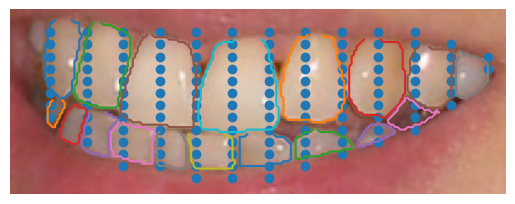

100%|██████████| 131/131 [02:00<00:00,  1.08it/s]


In [2]:
sss.find_all_tooth()
sss.tooth.polygons

In [ ]:
len(sss.tooth.polygons)

In [ ]:
sss.boximg.shape

In [ ]:
sss.tooth.polygons

In [ ]:
from lib.Base64Converter import path_to_base64
from lib.Polygon import PolygonSet,Polygon
#from lib.SMILE import SMILE
import matplotlib.pyplot as plt

from skimage import io
import numpy as np
#from PIL import Image
import cv2
import mediapipe as mp
#from segment_anything 
from lib.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import json
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
sam_checkpoint = f"{os.path.abspath(os.getcwd())}/lib/sam_vit_h_4b8939.pth"
model_type = "default"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(
    device='cuda'
    )
predictor = SamPredictor(sam)




In [ ]:
input_point=np.array([[50, 14]])
input_label=np.array([1])
def show_points(coords, labels, ax, marker_size=375):
    labels=np.array(labels)
    pos_points = np.array(coords[labels==1])
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

plt.figure(figsize=(10,10))
plt.imshow(sss.boximg)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [ ]:
#from lib.PolygonSet import PolygonSet
plt.imshow(sss.boximg)

grid=np.array([pt-sss.box_pol for pt in np.array(sss.grid)])

def mask_to_pol(mask):
    mask=np.array(mask, dtype='uint8')

    contours, hierarchy = cv2.findContours(mask*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    h,w=mask.shape

    pol=contours[0].reshape(-1,2)
    #pol=[ [round(p[0]/w,3),round(p[1]/h,3)]  for p in pol]
    return np.array(pol)

def polygon_area(points):
    area = 0
    q = points[-1]
    for p in points:
        area += p[0] * q[1] - p[1] * q[0]
        q = p
    return int(abs(area / 2))


tooth=PolygonSet()

for pt in grid:
    

    masks, scores, logits = predictor.predict(
        point_coords=np.array([pt]),
        point_labels=np.array([1]),
        multimask_output=True,
    )
    
    for mask,score in zip(masks, scores):
        pp=mask_to_pol(mask)

        if score<0.95:
            continue

        if (max(pp[:,0])-min(pp[:,0]))/sss.boximg.shape[1]>0.2:
            continue

        if sss.boximg.shape[0]*sss.boximg.shape[1]/300>polygon_area(pp):
            continue


        print(len(pp),score,(max(pp[:,0])-min(pp[:,0]))/sss.boximg.shape[1])
        try:
            tooth.append(pp)
        except:
            pass
        
        """plt.imshow(nowfig.boximg)
        show_points(np.array([pt]), [1], plt.gca())
        plt.plot(pp[:,0],pp[:,1])
        #show_mask(mask, plt.gca(),random_color=True)
        plt.axis('on')
        plt.show() """

plt.imshow(sss.boximg)
for pol in tooth.polygons:
    plt.plot(pol[:,0],pol[:,1])
plt.axis('off')
plt.show()

In [ ]:
import math
class Polygon:
    def __init__(self,arr):
        self.points=np.array(arr)
        self.n=len(self.points)
        self.area=self.count_area()
        self.box=[min(self.points[:,0]),max(self.points[:,0]),min(self.points[:,1]),max(self.points[:,1])]#lrud
        pass
    def isin(self,pt):
        def interpolate_x(y,p1,p2):
            if (p1[1]==p2[1] or y==p1[1]):
                return p1[0]
            return p1[0] + (p2[0] - p1[0]) * (y - p1[1]) / (p2[1] - p1[1])
        
        c=False
        tim=0
        for i in range(self.n):
            p1=self.points[i-1]
            p2=self.points[i]
            if ((p1[1]-pt[1]>0)^(p2[1]-pt[1]>0)) and (pt[0]-p1[0])*(p2[1]-p1[1])-(pt[1]-p1[1])*(p2[0]-p1[0])==0 :
                #print(pt)
                return True
        
            
            if ((p1[1]-pt[1]>0)^(p2[1]-pt[1]>0)) and pt[0]<interpolate_x(pt[1], p1, p2):
                #print(pt,interpolate_x(pt[1], p1, p2) )
                c=not c
                tim+=1
        #if tim in [0,1,2,3,5,7]:
            #return False
        return c


        
        """return np.array([Polygon([pt,self.points[i],self.points[(i+1)%self.n]]).area*self.area>=0 for i in range(self.n)]).all()"""
    
    def count_area(self):
        area = 0
        q = self.points[-1]
        for p in self.points:
            area += p[0] * q[1] - p[1] * q[0]
            q = p
        return -area / 2

    def show(self):
        x=self.points[:,0]
        y=self.points[:,1]
        if (self.points[-1]!=self.points[0]).any():
            x=np.append(x,x[:1])
            y=np.append(y,y[:1])
        #mask=np.zeros(self, np.uint8)
        plt.figure(figsize=(10,10))
        plt.axis('on')
        plt.plot(x,y,'black')
        plt.fill(x,y, 'r')


        plt.show()
        #plt.fill(self.points[:,0],self.points[:,1],'b',alpha=0.5)
        pass
    def expand(self,x):
        v1=[self.points[0][0]-self.points[-1][0],self.points[0][1]-self.points[-1][1]]
        l1=math.sqrt(v1[0]*v1[0]+v1[1]*v1[1])
        v2=[self.points[1][0]-self.points[0][0],self.points[1][1]-self.points[0][1]]
        l2=math.sqrt(v2[0]*v2[0]+v2[1]*v2[1])
        result=[]
        for i in range(self.n):
            q=[int(self.points[i][0]+x*(v1[0]/l1-v2[0]/l2)),int(self.points[i][1]+x*(v1[1]/l1-v2[1]/l2))]
            result.append(q)
            v1=v2
            l1=l2
            v2=[self.points[(i+2)%self.n][0]-self.points[(i+1)%self.n][0],self.points[(i+2)%self.n][1]-self.points[(i+1)%self.n][1]]
            l2=math.sqrt(v2[0]*v2[0]+v2[1]*v2[1])
        return Polygon(result)
    def gen_grid(self,l):
        result=[]
        #x,y=self.box[0],self.box[2]
        for x in np.arange(self.box[0], self.box[1], l):
            for y in np.arange(self.box[2], self.box[3], l):
                if self.isin([x,y]):
                    #print(self.isin([x,y]))
                    result.append([x,y])
        return np.array(result)
    def pol_to_mask(self):
            mask=np.zeros([1000,1000], np.uint8)
            #cv2.polylines(mask, np.int32([pol]), isClosed=True,color=1, thickness=1)
            cv2.fillPoly(mask,self.points,1)
            return mask

In [ ]:
from .lib.Polygon import Polygon,PolygonSet
p=Polygon(sss.mouse[::-1])
#p.show()

plt.figure(figsize=(10,10))
grid=p.gen_grid(5)
plt.scatter(grid[:,0],grid[:,1])
plt.plot(sss.mouse[:,0],sss.mouse[:,1])

In [ ]:
from lib.Polygon import Polygon,PolygonSet

pol=Polygon([[67 , 0], [67,  5], [66 , 6], [66, 20], [67 ,21], [67 ,23], [70 ,26], [72, 26], [73, 27], [77 ,27], [78 ,28], [88, 28], [89 ,27], [90 ,27], [90, 24], [89 ,23], [89 ,12], [90 ,11], [90 , 5], [91 , 4], [91 , 0]])
pol.area
pol.show()

In [ ]:
pol.isin([0,0])

In [ ]:
plt.plot(pol.gen_grid(0.3)[:,1],pol.gen_grid(0.3)[:,0])

In [ ]:
import torch
import numpy as np

device = torch.device("mps")
N = 3

A = torch.rand([N,N],dtype=torch.float32)*2 - 1
B = torch.rand([N,N],dtype=torch.float32)*5 - 2.5

C = A @ B
C

